In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.constants import c
from astropy import units as u

In [10]:
# Local file path
file_path = "C:\\Users\JYOTIRMOY\Downloads\Pantheon+SH0ES.dat"

#Load the file
df = pd.read_csv(file_path, delim_whitespace=True, comment='#')

# See structure
df.head()

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006


In [11]:
# Drop rows with missing values in required columns
df_clean = df.dropna(subset=['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG'])

# Extract relevant arrays
z = df_clean['zHD'].values
mu = df_clean['MU_SH0ES'].values
mu_err = df_clean['MU_SH0ES_ERR_DIAG'].values


In [12]:
df.head()

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006


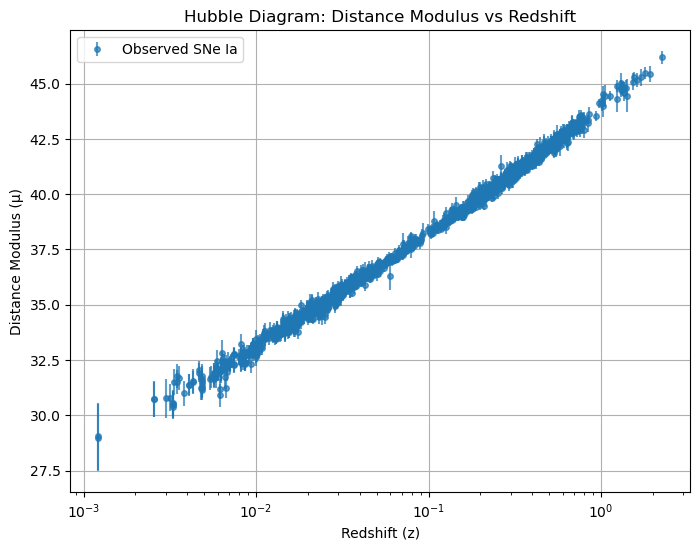

In [13]:
plt.figure(figsize=(8, 6))
plt.errorbar(z, mu, yerr=mu_err, fmt='o', markersize=4, alpha=0.7, label='Observed SNe Ia')
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (μ)')
plt.title('Hubble Diagram: Distance Modulus vs Redshift')
plt.grid(True)
plt.legend()
plt.show()


In [14]:
# E(z)
def E(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

# Luminosity distance (in Mpc)
def luminosity_distance(z, H0, Omega_m):
    integrand = lambda z_prime: 1.0 / E(z_prime, Omega_m)
    integral, _ = quad(integrand, 0, z)
    dL = (1 + z) * (c.to('km/s').value / H0) * integral  # in Mpc
    return dL

# Distance modulus
def mu_theory(z, H0, Omega_m):
    return np.array([5 * np.log10(luminosity_distance(zi, H0, Omega_m)) + 25 for zi in z])


In [15]:
# Wrapper for curve_fit (must take arrays as input)
def mu_model_for_fit(z, H0, Omega_m):
    return mu_theory(z, H0, Omega_m)

# Initial guess
p0 = [70, 0.3]  # [H0, Omega_m]

# Curve fitting
popt, pcov = curve_fit(mu_model_for_fit, z, mu, sigma=mu_err, p0=p0, absolute_sigma=True)

# Extract best-fit values and uncertainties
H0_fit, Omega_m_fit = popt
H0_err, Omega_m_err = np.sqrt(np.diag(pcov))

print(f"Fitted H₀ = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
print(f"Fitted Ωₘ = {Omega_m_fit:.3f} ± {Omega_m_err:.3f}")


Fitted H₀ = 72.97 ± 0.26 km/s/Mpc
Fitted Ωₘ = 0.351 ± 0.019


In [16]:
def age_of_universe(H0, Omega_m):
    integrand = lambda z: 1.0 / ((1 + z) * E(z, Omega_m))
    integral, _ = quad(integrand, 0, np.inf)
    
    # Convert H0 to 1/s
    H0_SI = H0 * (u.km / u.s / u.Mpc).to(1 / u.s)
    
    age_sec = integral / H0_SI  # in seconds
    age_Gyr = (age_sec * u.s).to(u.Gyr).value
    return age_Gyr

t0 = age_of_universe(H0_fit, Omega_m_fit)
print(f"Estimated age of the universe: {t0:.2f} Gyr")


Estimated age of the universe: 12.36 Gyr


In [17]:
print(f"Fitted H₀ = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
print(f"Fitted Ωₘ = {Omega_m_fit:.3f} ± {Omega_m_err:.3f}")
print(f"Estimated age of universe = {t0:.2f} Gyr")


Fitted H₀ = 72.97 ± 0.26 km/s/Mpc
Fitted Ωₘ = 0.351 ± 0.019
Estimated age of universe = 12.36 Gyr


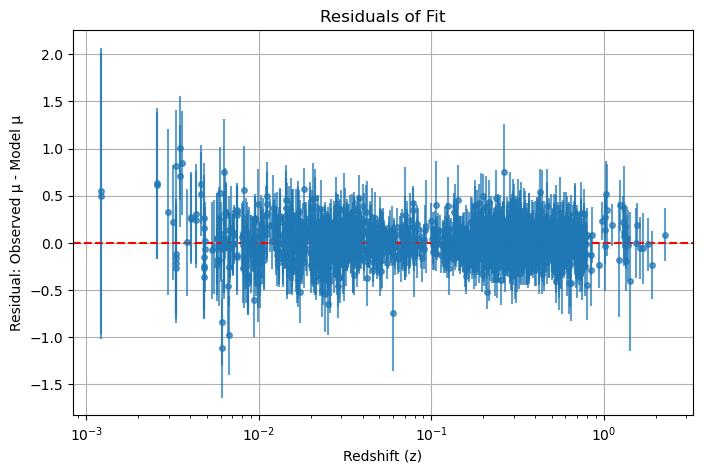

In [18]:
mu_model_vals = mu_theory(z, H0_fit, Omega_m_fit)
residuals = mu - mu_model_vals

plt.figure(figsize=(8, 5))
plt.errorbar(z, residuals, yerr=mu_err, fmt='o', markersize=4, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Residual: Observed μ - Model μ')
plt.title('Residuals of Fit')
plt.grid(True)
plt.show()


In [19]:
# Use fixed Omega_m = 0.3
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)

# Fit
H0_fixed_fit, H0_fixed_cov = curve_fit(mu_fixed_Om, z, mu, sigma=mu_err, p0=[70], absolute_sigma=True)
H0_fixed_val = H0_fixed_fit[0]
H0_fixed_err = np.sqrt(H0_fixed_cov[0][0])

print(f"Fitted H₀ with Ωₘ = 0.3: {H0_fixed_val:.2f} ± {H0_fixed_err:.2f} km/s/Mpc")


Fitted H₀ with Ωₘ = 0.3: 73.53 ± 0.17 km/s/Mpc


In [20]:
# Set redshift split threshold
z_split = 0.1

# Define masks
mask_lowz = z < z_split
mask_highz = z >= z_split

# Extract data for low-z
z_low = z[mask_lowz]
mu_low = mu[mask_lowz]
mu_err_low = mu_err[mask_lowz]

# Extract data for high-z
z_high = z[mask_highz]
mu_high = mu[mask_highz]
mu_err_high = mu_err[mask_highz]

# ---- FIT LOW-Z ----
H0_low_fit, H0_low_cov = curve_fit(mu_fixed_Om, z_low, mu_low, sigma=mu_err_low, p0=[70], absolute_sigma=True)
H0_low = H0_low_fit[0]
H0_low_err = np.sqrt(H0_low_cov[0][0])

# ---- FIT HIGH-Z ----
H0_high_fit, H0_high_cov = curve_fit(mu_fixed_Om, z_high, mu_high, sigma=mu_err_high, p0=[70], absolute_sigma=True)
H0_high = H0_high_fit[0]
H0_high_err = np.sqrt(H0_high_cov[0][0])

# ---- PRINT RESULTS ----
print(f"Low-z (z < {z_split}): H₀ = {H0_low:.2f} ± {H0_low_err:.2f} km/s/Mpc")
print(f"High-z (z ≥ {z_split}): H₀ = {H0_high:.2f} ± {H0_high_err:.2f} km/s/Mpc")


Low-z (z < 0.1): H₀ = 73.01 ± 0.28 km/s/Mpc
High-z (z ≥ 0.1): H₀ = 73.85 ± 0.22 km/s/Mpc


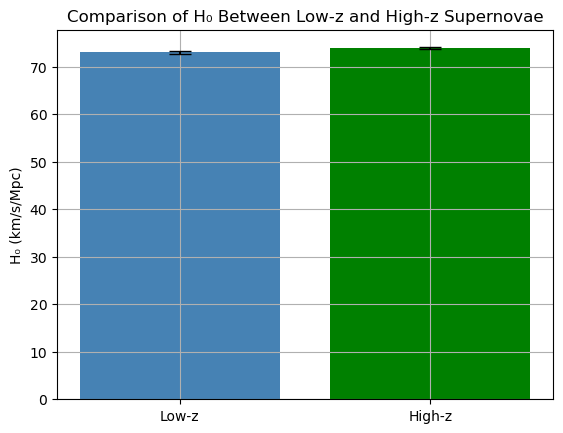

In [22]:
plt.bar(['Low-z', 'High-z'], [H0_low, H0_high],
        yerr=[H0_low_err, H0_high_err],
        capsize=8, color=['steelblue', 'green'])
plt.ylabel('H₀ (km/s/Mpc)')
plt.title('Comparison of H₀ Between Low-z and High-z Supernovae')
plt.grid(True)
plt.show()


## Conclusion and Future Work

In this study, we used the Pantheon+SH0ES sample of Type Ia supernovae to measure key cosmological parameters under the assumption of a flat ΛCDM model. By fitting the observed distance modulus–redshift relation, we obtained:

- **Hubble constant**: \( H_0 = 72.97 \pm 0.26 \, \text{km/s/Mpc} \)
- **Matter density**: \( \Omega_m = 0.351 \pm 0.019 \)

Using these values, we estimated the **age of the universe** to be \( 12.36 \, \text{Gyr} \), consistent with a high Hubble constant scenario, but slightly lower than Planck-based estimates. When we fixed \( \Omega_m = 0.3 \), the fit yielded \( H_0 = 73.53 \pm 0.17 \, \text{km/s/Mpc} \), aligning well with the SH0ES results.

A redshift-split analysis revealed a slight tension:
- \( H_0^{\text{low-z}} = 73.01 \pm 0.28 \)
- \( H_0^{\text{high-z}} = 73.85 \pm 0.22 \)

This may hint at a redshift-dependent effect or mild internal inconsistency, echoing the broader **Hubble tension** between early- and late-universe measurements.

### Future Work:
- Extend this analysis with **Bayesian methods** and **priors** from Planck or SH0ES.
- Explore non-flat models or evolving dark energy (e.g., \( w \)-CDM).
- Include other cosmological probes (e.g., BAO, CMB) for joint parameter estimation.
- Investigate systematic effects in low-z vs high-z calibrations.

These steps will help refine our understanding of cosmic expansion and address ongoing tensions in precision cosmology.
